# Python Basic Statistics: `scipy.stats` (normalumas ir koreliacija)

Šiame užraše pateikiami praktiniai pavyzdžiai, kaip naudoti `scipy.stats` funkcijas: `shapiro`, `normaltest`, `anderson`, `pearsonr`, `spearmanr`, `kendalltau`.

Tikslas – suprasti:
- ką kiekvienas testas tikrina,
- kada jį taikyti duomenų analitikoje,
- kaip interpretuoti rezultatą,
- kokios yra gerosios praktikos ir dažniausios klaidos.


## 1. Aplinka ir importai

Toliau naudojami paketai:
- `numpy` – duomenų generavimui ir masyvams
- `pandas` – patogiam duomenų tvarkymui
- `matplotlib` – vizualizacijoms
- `scipy.stats` – statistiniams testams


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import shapiro, normaltest, anderson
from scipy.stats import pearsonr, spearmanr, kendalltau

np.random.seed(42)  # kad rezultatai būtų atkartojami


## 2. Pavyzdiniai duomenys

Sugeneruojami keli tipiniai scenarijai:
1) Normaliai pasiskirstę duomenys
2) Dešiniškai pasvirę duomenys (lognormal)
3) Duomenys su išskirtimis (outlier)
4) Du koreliacijos scenarijai: tiesinis ir monotoniškas netiesinis ryšys


In [3]:
n = 500

x_normal = np.random.normal(loc=0, scale=1, size=n)
x_lognormal = np.random.lognormal(mean=0.0, sigma=0.6, size=n)

x_outliers = x_normal.copy()
x_outliers[:5] = x_outliers[:5] + 8  # 5 didelės išskirtys

df = pd.DataFrame({
    "x_normal": x_normal,
    "x_lognormal": x_lognormal,
    "x_outliers": x_outliers
})

df.head()


,x_normal,x_lognormal,x_outliers
0,0.496714,1.743172,8.496714
1,-0.138264,3.144485,7.861736
2,0.647689,0.432082,8.647689
3,1.523030,1.401834,9.523030
4,-0.234153,0.676796,7.765847


## 3. Greita vizualinė diagnostika

Prieš statistinius testus verta pasižiūrėti į histogramas. Tai padeda pamatyti asimetriją, uodegas ir galimas išskirtines reikšmes.


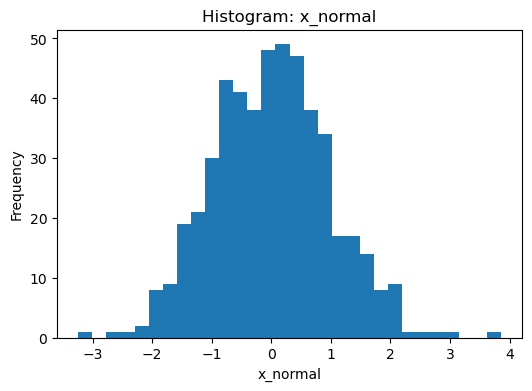

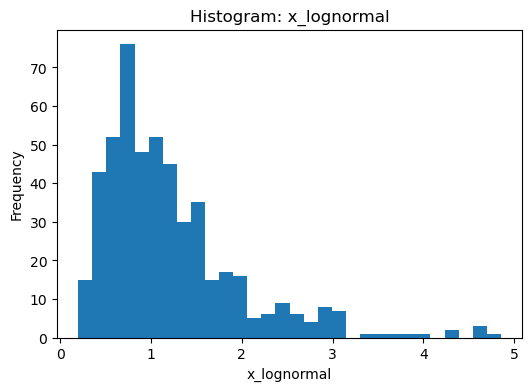

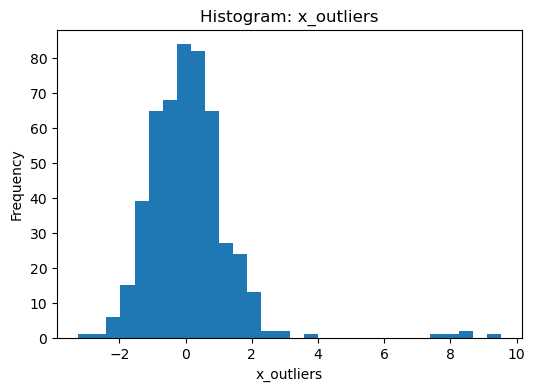

In [4]:
cols = ["x_normal", "x_lognormal", "x_outliers"]

for col in cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col], bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


## 4. Normalumo testai

Normalumo testai atsako į klausimą: ar imties duomenys suderinami su normaliojo skirstinio prielaida?
Tipinė nulio hipotezė (H0): duomenys normalūs. Jei p reikšmė maža (pvz., < 0.05), H0 atmetama.

Praktinė pastaba: didelėse imtyse testai būna labai jautrūs, todėl rezultatą visada verta derinti su vizualizacija.

**stat** – testo statistika.  
Tai skaitinė reikšmė, rodanti, kiek stipriai duomenys nukrypsta nuo normalumo.  
Kuo didesnė stat reikšmė, tuo didesnis nukrypimas.

**p-value** – tikimybė gauti tokį arba dar ekstremalesnį rezultatą, jei H0 yra teisinga.  
Ji naudojama sprendimui priimti.

Interpretacija:  
- Didelė stat + labai maža p → stiprus nenormalumas  
- Maža stat + didelė p → duomenys suderinami su normalumu



### 4.1 Shapiro–Wilk (`shapiro`)

Grąžina statistiką W ir p reikšmę. Kuo W arčiau 1, tuo labiau panašu į normalumą, tačiau sprendimui svarbiausia p reikšmė.


In [5]:
def run_shapiro(series, name):
    stat, p = shapiro(series)
    print(f"{name}: W={stat:.4f}, p-value={p:.3e}")

for col in cols:
    run_shapiro(df[col], col)


x_normal: W=0.9967, p-value=4.014e-01
x_lognormal: W=0.8489, p-value=1.818e-21
x_outliers: W=0.8125, p-value=1.108e-23


### Shapiro–Wilk normalumo testas

H0: duomenys yra normaliai pasiskirstę  
H1: duomenys nėra normalūs  

Sprendimas:  
- Jei p > 0.05 → neatmetame H0 → laikome, kad pasiskirstymas normalus  
- Jei p < 0.05 → atmetame H0 → pasiskirstymas nenormalus  

Rezultatai:

x_normal: W=0.9967, p=0.4014  
→ p > 0.05 → duomenys atitinka normalumo prielaidą  

x_lognormal: W=0.8489, p≈0  
→ p < 0.05 → pasiskirstymas nenormalus  

x_outliers: W=0.8125, p≈0  
→ p < 0.05 → pasiskirstymas nenormalus (galimi outlieriai)


### 4.2 D’Agostino–Pearson (`normaltest`)

Tikrina normalumą remiantis asimetrija ir smailumu. Grąžina testinę statistiką ir p reikšmę.


In [6]:
def run_normaltest(series, name):
    stat, p = normaltest(series)
    print(f"{name}: stat={stat:.4f}, p-value={p:.3e}")

for col in cols:
    run_normaltest(df[col], col)


x_normal: stat=4.2235, p-value=1.210e-01
x_lognormal: stat=186.8058, p-value=2.727e-41
x_outliers: stat=344.8469, p-value=1.311e-75


### Pearson normality testas

H0: duomenys yra normaliai pasiskirstę  
H1: duomenys nėra normalūs  

Sprendimas:  
- Jei p > 0.05 → neatmetame H0 → laikome, kad pasiskirstymas normalus  
- Jei p < 0.05 → atmetame H0 → pasiskirstymas nenormalus  

Rezultatai:

x_normal: stat=4.2235, p=0.1210  
→ p > 0.05 → duomenys atitinka normalumo prielaidą  

x_lognormal: stat=186.8058, p≈0  
→ p < 0.05 → pasiskirstymas nenormalus  

x_outliers: stat=344.8469, p≈0  
→ p < 0.05 → pasiskirstymas nenormalus (stiprus nukrypimas nuo normalumo)


### 4.3 Anderson–Darling (`anderson`)

Rezultatai interpretuojami lyginant testinę statistiką su kritinėmis reikšmėmis keliems reikšmingumo lygiams.
Jei statistika > kritinė reikšmė, normalumo prielaida atmetama.


### Anderson–Darling test funkcija

run_anderson(series, name)  
– funkcija atlieka Anderson–Darling normalumo testą vienam kintamajam.

res = anderson(series, dist="norm")  
– atliekamas testas, tikrinant ar duomenys atitinka normalųjį pasiskirstymą.

res.statistic  
– testo statistika (AD stat).  
Kuo ji didesnė, tuo stipresnis nukrypimas nuo normalumo.

res.significance_level  
– reikšmingumo lygiai (%), pvz. 15, 10, 5, 2.5, 1.

res.critical_values  
– kritinės reikšmės kiekvienam reikšmingumo lygiui.

Sprendimo logika:  
Jei statistika > kritinė reikšmė → REJECT (atmetame normalumą).  
Jei statistika ≤ kritinė reikšmė → FAIL TO REJECT (normalumo neatmetame).

for col in cols:  
– testas paleidžiamas visiems stulpeliams iš sąrašo cols.


In [7]:
def run_anderson(series, name):
    res = anderson(series, dist="norm")
    print(f"{name}: AD stat={res.statistic:.4f}")
    for sl, cv in zip(res.significance_level, res.critical_values):
        alpha = sl / 100
        decision = "REJECT" if res.statistic > cv else "FAIL TO REJECT"
        print(f"  alpha={alpha:.2f}, critical={cv:.4f} -> {decision}")

for col in cols:
    run_anderson(df[col], col)


x_normal: AD stat=0.2978
  alpha=0.15, critical=0.5710 -> FAIL TO REJECT
  alpha=0.10, critical=0.6510 -> FAIL TO REJECT
  alpha=0.05, critical=0.7810 -> FAIL TO REJECT
  alpha=0.03, critical=0.9110 -> FAIL TO REJECT
  alpha=0.01, critical=1.0830 -> FAIL TO REJECT
x_lognormal: AD stat=18.7834
  alpha=0.15, critical=0.5710 -> REJECT
  alpha=0.10, critical=0.6510 -> REJECT
  alpha=0.05, critical=0.7810 -> REJECT
  alpha=0.03, critical=0.9110 -> REJECT
  alpha=0.01, critical=1.0830 -> REJECT
x_outliers: AD stat=9.4598
  alpha=0.15, critical=0.5710 -> REJECT
  alpha=0.10, critical=0.6510 -> REJECT
  alpha=0.05, critical=0.7810 -> REJECT
  alpha=0.03, critical=0.9110 -> REJECT
  alpha=0.01, critical=1.0830 -> REJECT


### 4.4 Gerosios praktikos ir dažniausios klaidos (normalumas)

Geroji praktika: vizualizacija + testas + kontekstas.
Dažna klaida: testuoti identifikatorių (Id) ar kodus, kurie nėra matuojamas reiškinys.


## 5. Koreliacijos koeficientai

Koreliacija matuoja ryšio kryptį ir stiprumą, bet ne priežastingumą.
Pearson – tiesiniam ryšiui, Spearman/Kendall – monotoniškam ir atsparesni outlier.


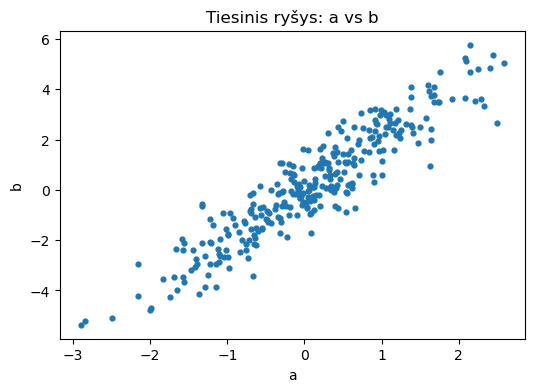

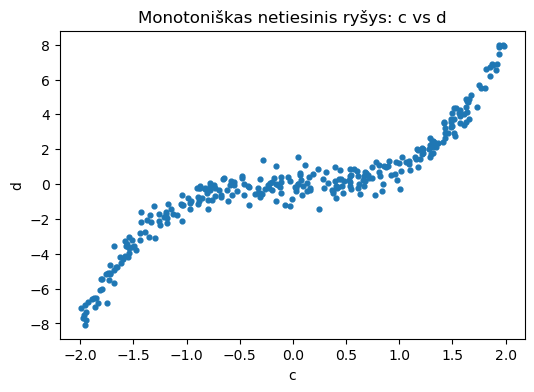

In [8]:
n = 300

a = np.random.normal(0, 1, n)
b = 2.0 * a + np.random.normal(0, 0.8, n)

c = np.random.uniform(-2, 2, n)
d = c**3 + np.random.normal(0, 0.5, n)

plt.figure(figsize=(6,4))
plt.scatter(a, b, s=12)
plt.title("Tiesinis ryšys: a vs b")
plt.xlabel("a")
plt.ylabel("b")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(c, d, s=12)
plt.title("Monotoniškas netiesinis ryšys: c vs d")
plt.xlabel("c")
plt.ylabel("d")
plt.show()


### Koreliacijos ataskaitos funkcija

corr_report(x, y, label)  
– funkcija apskaičiuoja trijų tipų koreliaciją tarp dviejų kintamųjų.

pearsonr(x, y)  
– Pearson koreliacija (matuoja tiesinį ryšį).

spearmanr(x, y)  
– Spearman koreliacija (matuoja monotonišką ryšį pagal rangus).

kendalltau(x, y)  
– Kendall tau koreliacija (ranginė, stabilesnė mažoms imtims).

r – koreliacijos koeficientas (nuo -1 iki 1).  
p – p-value, naudojama tikrinti H0: ryšio nėra.

Interpretacija:  
- r arti 1 arba -1 → stiprus ryšys  
- r arti 0 → silpnas arba nėra ryšio  
- p < 0.05 → ryšys statistiškai reikšmingas  

Funkcijos gale ji paleidžiama dviem poroms kintamųjų ir išspausdinami rezultatai.


In [9]:
def corr_report(x, y, label):
    r_p, p_p = pearsonr(x, y)
    r_s, p_s = spearmanr(x, y)
    r_k, p_k = kendalltau(x, y)
    print(label)
    print(f"  Pearson   r={r_p:.3f}, p={p_p:.3e}")
    print(f"  Spearman  r={r_s:.3f}, p={p_s:.3e}")
    print(f"  Kendall τ r={r_k:.3f}, p={p_k:.3e}")
    print()

corr_report(a, b, "a vs b (tiesinis)")
corr_report(c, d, "c vs d (monotoniškas netiesinis)")


a vs b (tiesinis)
  Pearson   r=0.928, p=1.074e-129
  Spearman  r=0.919, p=3.746e-122
  Kendall τ r=0.755, p=1.241e-84

c vs d (monotoniškas netiesinis)
  Pearson   r=0.907, p=2.844e-114
  Spearman  r=0.939, p=1.315e-140
  Kendall τ r=0.822, p=4.084e-100



### Koreliacijos interpretacija

a vs b (tiesinis)

Pearson r=0.928  
→ labai stiprus teigiamas tiesinis ryšys  

Spearman r=0.919  
Kendall τ=0.755  
→ taip pat stiprus monotoniškas ryšys  

Visų testų p ≈ 0  
→ ryšys statistiškai reikšmingas  

Išvada: aiškus stiprus tiesinis ryšys.

---

c vs d (monotoniškas netiesinis)

Pearson r=0.907  
→ stiprus ryšys, bet matuoja tik tiesiškumą  

Spearman r=0.939  
Kendall τ=0.822  
→ dar stipresnis monotoniškas ryšys  

Visų testų p ≈ 0  
→ ryšys statistiškai reikšmingas  

Išvada: ryšys stiprus, bet labiau monotoniškas nei griežtai tiesinis.


### 5.3 Gerosios praktikos ir dažniausios klaidos (koreliacija)

Geroji praktika: pradėti nuo scatter plot, įvertinti outlier, pasirinkti tinkamą koeficientą.
Dažna klaida: koreliaciją laikyti priežastimi.


## 6. Trumpai apie p reikšmę (p-value)

p reikšmė parodo, kiek tikėtina gauti stebėtą rezultatą, jei H0 teisinga.
Maža p reikšmė nereiškia didelio efekto ir nėra priežastingumo įrodymas.


## 7. Santrauka

Normalumas: `shapiro`, `normaltest`, `anderson`.
Koreliacija: `pearsonr`, `spearmanr`, `kendalltau`.
Pagrindinė taisyklė: visada derinti testus su vizualizacija ir kontekstu.
